### ДЗ №11. Transformers

Очень популярная статеечка http://jalammar.github.io/illustrated-transformer/
Просто по какой-то причине читать методичку (даже на русском языке) очень трудно. Даже код не всегда спасает. Такое чувство что это автоматический перевод (вот ведь ирония) какой-то оригинальной работы...

In [91]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import tensorflow_datasets as tfds

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True,
                               as_supervised=True)

In [5]:
train_examples, val_examples = examples['train'], examples['validation']

In [6]:
i = iter(train_examples)

In [7]:
example = i.next()

In [8]:
tf.print(example[0])

к : успех , перемены возможны только с оружием в руках .


In [9]:
tf.print(example[1])

c : success , the change is only coming through the barrel of the gun .


In [10]:
print(tf.get_static_value(example[0]).decode('utf-8'))

к : успех , перемены возможны только с оружием в руках .


In [11]:
# Сабворд токенизатор
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for ru, en in train_examples), target_vocab_size=2**13)

tokenizer_ru = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (ru.numpy() for ru, en in train_examples), target_vocab_size=2**13)

In [12]:
tokenized_string = tokenizer_en.encode('This is just a test')
tokenized_string

[8073, 139, 13, 54, 7, 2298]

In [13]:
tokenizer_en.decode(tokenized_string)

'This is just a test'

In [14]:
for token in tokenized_string:
    print(f'{token=} ===> "{tokenizer_en.decode([token])}"')

token=8073 ===> "T"
token=139 ===> "his "
token=13 ===> "is "
token=54 ===> "just "
token=7 ===> "a "
token=2298 ===> "test"


In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [16]:
# Функция кодирования (с добавлением метки начала и конца)

In [17]:
def encode(ru, en):
    ru = [tokenizer_ru.vocab_size] + tokenizer_ru.encode(
      ru.numpy()) + [tokenizer_ru.vocab_size+1]

    en = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      en.numpy()) + [tokenizer_en.vocab_size+1]

    return ru, en

In [18]:
def tf_encode(ru, en):
    result_ru, result_en = tf.py_function(encode, [ru, en], [tf.int64, tf.int64])
    result_ru.set_shape([None])
    result_en.set_shape([None])

    return result_ru, result_en

In [19]:
MAX_LENGTH = 40

In [20]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [21]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [22]:
ru_batch, en_batch = next(iter(val_dataset))
ru_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8179,   57,   86, ...,    0,    0,    0],
        [8179,    3,   38, ...,    0,    0,    0],
        [8179,   57,  135, ...,    0,    0,    0],
        ...,
        [8179,    3,    7, ...,    0,    0,    0],
        [8179,  138,  250, ...,    0,    0,    0],
        [8179,   19,    7, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8245,   90,  101, ...,    0,    0,    0],
        [8245,   70,   25, ...,    0,    0,    0],
        [8245,   90,  153, ...,    0,    0,    0],
        ...,
        [8245,    4,   18, ...,    0,    0,    0],
        [8245,   19,   59, ...,    0,    0,    0],
        [8245,   24,   18, ...,    0,    0,    0]])>)

In [23]:
ru_batch[0]

<tf.Tensor: shape=(38,), dtype=int64, numpy=
array([8179,   57,   86,   54,  578,   84, 4550, 1003, 5905, 6326, 1197,
          2, 8180,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>

In [24]:
# Positional encoder - готовим матрицу векторов (для всех позиций в предложении не более длины max_len)
# Потом будем их (соответствующий позиции вектор) добавлять к эмбеддингу каждого слова, 
# как кодированную позицию слова в предложении

$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $

$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $

In [25]:
np.arange(10)[:, np.newaxis]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [26]:
(np.arange(10)[np.newaxis, :]//2) * 2

array([[0, 0, 2, 2, 4, 4, 6, 6, 8, 8]])

In [27]:
1 / np.power(10000, (2 * (np.arange(50)[np.newaxis, :]//2)) / np.float32(512))

array([[1.        , 1.        , 0.96466162, 0.96466162, 0.93057204,
        0.93057204, 0.89768713, 0.89768713, 0.86596432, 0.86596432,
        0.83536255, 0.83536255, 0.80584219, 0.80584219, 0.77736503,
        0.77736503, 0.74989421, 0.74989421, 0.72339416, 0.72339416,
        0.69783058, 0.69783058, 0.67317038, 0.67317038, 0.64938163,
        0.64938163, 0.62643354, 0.62643354, 0.60429639, 0.60429639,
        0.58294153, 0.58294153, 0.56234133, 0.56234133, 0.54246909,
        0.54246909, 0.52329911, 0.52329911, 0.50480657, 0.50480657,
        0.48696753, 0.48696753, 0.46975888, 0.46975888, 0.45315836,
        0.45315836, 0.43714448, 0.43714448, 0.4216965 , 0.4216965 ]])

In [28]:
# То, от чего берется синус (для четных элементов) и косинус для нечетных
rates = (1 / np.power(10000, (2 * (np.arange(5)[np.newaxis, :]//2))\
                      / np.float32(512))) * np.arange(5)[:, np.newaxis]
rates

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.96466162, 0.96466162, 0.93057204],
       [2.        , 2.        , 1.92932324, 1.92932324, 1.86114408],
       [3.        , 3.        , 2.89398486, 2.89398486, 2.79171612],
       [4.        , 4.        , 3.85864648, 3.85864648, 3.72228816]])

In [29]:
2 * (np.arange(10)[np.newaxis, :]//2)

array([[0, 0, 2, 2, 4, 4, 6, 6, 8, 8]])

In [30]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [31]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [32]:
positional_encoding(5, 512)

<tf.Tensor: shape=(1, 5, 512), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  5.4030228e-01,  8.2185620e-01, ...,
          1.0000000e+00,  1.0366329e-04,  1.0000000e+00],
        [ 9.0929741e-01, -4.1614684e-01,  9.3641472e-01, ...,
          1.0000000e+00,  2.0732658e-04,  1.0000000e+00],
        [ 1.4112000e-01, -9.8999250e-01,  2.4508542e-01, ...,
          9.9999994e-01,  3.1098988e-04,  9.9999994e-01],
        [-7.5680250e-01, -6.5364361e-01, -6.5716684e-01, ...,
          9.9999988e-01,  4.1465316e-04,  9.9999994e-01]]], dtype=float32)>

In [33]:
# Функция маскирующая паддинговые нули... не супер понятно для чего там эти два доп. измерения
# Написано для логитов внимания - вопрос - почему два....
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [34]:
# Маска закрывающая еще не предсказанную часть фразы. Чтобы самовнимание ее не использовало
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [35]:
# Scaled dot product attention
# Функция вычисления весов самовнимания. В нее подаются по три вектора Q, K, V производные из эмбеддингов слов.
# Для каждого слова берется Q и скалярно перемножается с K векторами всех слов - полученные веса скейлятся 
# на корень из длины вектора, от них берется софтмакс и на них множатся V вектора. 
# Все соскейленные V вектора суммируются в итоговый вектор self attention (output)

def scaled_dot_product_attention(q, k, v, mask=None):

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # Непонятно, почему так? Зачем отнимать огромное значение, почему не умножить на что нибудь маленькое

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [36]:
q = tf.constant([[0.0, 1.0, 2.0, 3.0]])
k = tf.constant([[1.0, 0.0, 1.0, 0.0]])
v = tf.constant([[5.0, 5.0, 5.0, 5.0]])

In [37]:
tf.matmul(q, k, transpose_b=True)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.]], dtype=float32)>

In [38]:
scaled_dot_product_attention(q, k, v)

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5., 5., 5., 5.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>)

In [39]:
mask = tf.constant([[1]], dtype=tf.float32)

In [40]:
scaled_dot_product_attention(q, k, v, mask)

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5., 5., 5., 5.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>)

In [46]:
q = tf.constant([[0.0, 1.0, 2.0, 3.0], [1.0, 2.0, 3.0, 5.0]])
k = tf.constant([[1.0, 0.0, 1.0, 0.0], [2.0, 1.0, 0.0, 0.0]])
v = tf.constant([[5.0, 5.0, 5.0, 5.0], [3.0, 3.0, 35.0, 3.0]])
scaled_dot_product_attention(q, k, v)

(<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 4.244919,  4.244919, 16.32622 ,  4.244919],
        [ 4.      ,  4.      , 20.      ,  4.      ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.62245935, 0.37754068],
        [0.5       , 0.5       ]], dtype=float32)>)

In [41]:
# Многоголовость внимания
# Слоев внимания несколько. Для каждого слоя внимания мы прогоняем эмбеддинги через три dense слоя wq, wk, wv
# Таким образом получая Q K V вектора, которые разбираем на части с помощью reshape (сколько голов внимания - столько частей)
# Для всех вычисляется самовнимание и мы собираем матрицы векторов V из каждого "внимания" и конкатенейтим их (также через reshape). 
# И прогоняем через выходной FC слой. 

In [42]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [43]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [44]:
# Полносвязная сеточка (будет использоваться в конце енкодера)

In [45]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [47]:
# Энкодер в трансформере состоит из нескольких повторяющихся слоёв. Вот один слой энкодера
# В нем Multi-Head-Attention блок, выходная полносвязная сеть, и блоки нормализации и дропаут..
# Сначала данные попадают в MHA, затем дропаут, затем нормалайз, затем в полносвязную сеть и снова дропаут и нормалайз
# Кроме того есть два скип-соединения, один обходит MHA с дропаутом, 
# второй полносвязную сеть с дропаутом, чтобы при большой глубине не затухали градиенты

In [48]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [49]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [51]:
# Собственно сам энкодер
# Берет исходные фразы, делает для них эмбеддинги, скейлит их на корень из размерности эмбеддинга, добавляет позишн
# И прогоняет их через какое-то количество энкодер-слоев (рассмотренных выше)

In [52]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)
    
    
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x  # (batch_size, input_seq_len, d_model)

In [62]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [55]:
# Декодер. Так-же как и энкодер состоит из повторяющихся слоёв. 
# Каждый слой берет входные данные (эмбеддинги фразы или то, что пришло из предыдущего слоя декодера)
# Вычисляет много-слойное само-внимание (с ограничением по маске). Маска в данном случае не дает вниманию
# Вычислять скор с токенами которые находятся правее предсказываемого в данный момент. (поскольку декодер 
# генерирует результат токен за токеном - маска сначала закрывает все токены, потом постепенно сдвигаясь вправо
# открывает ту часть которая уже была обработана)
# Далее следует дропаут и слой нормализации со скип-соединением снизу.
# После этого вычисляется скор еще одного самовнимания, на этот раз в нем используются Q и K вектора из Энкодера.
# А V вектор используется от первого внимания (после дропаута и нормализации)
# Дальше снова дропаут и нормалайз со скипом. 
# Далее полносвязная сеть и еще один проход дропаут и нормалайз. 
# И результат (V вектора, и веса первого и второго внимания) выдаются наружу для передачи в следующий слой декодера

In [56]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [57]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [60]:
# Собственно сам Декодер
# Все уже было расписано выше в основном.. Берем входные данные, эмбеддим их, скейлим корнем из глубины,
# Добавляем позишн энкодинг, дальше дропаут и прогоняем через пачку слоев декодера (зачем-то сохраняем веса внимания)

In [59]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [63]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [65]:
# Весь Трансформер.. Энкодер, декодер и финальный полносвязный слой

In [66]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

In [67]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [68]:
# Гиперпараметры... Урезаны для того чтобы это не исполнялось вечность... 
# В оригинальном трансформере эмбеддинг 512, слоев энкодере и декодере по 6, размерность полносвязных слоев 2048
# Здесь - 128, 4, 512..

In [70]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_ru.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

Оптимайзер с variable learning rate. Формула из пэйпера [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [71]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [72]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

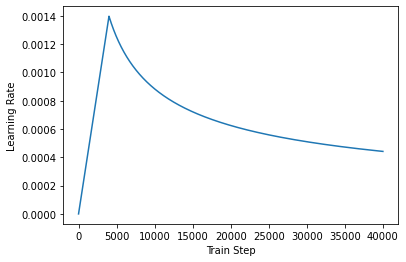

In [73]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [77]:
# Лосс функция. И метрика. Поскольку секвенции имеют паддинг - нужно исключать его из вычислений

In [75]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [76]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [78]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [80]:
# Попробуем по-тренировать

In [81]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [82]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [84]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [87]:
# Процесс тренировки - в энкодер подаются исходные фразы, 
# В декодер подаются таргетный фразы. Таргет подается в двух видах, снизу в исходном, сверху в сдвинутом на -1, 
# Поскольку предсказание энкодера (и процесс тренировки тоже) происходит в пошаговом режиме (предсказывается
# по одному токену за шаг, а следующее предсказание строится на результатах предыдущего)
# Сдвиг таргета делается чтобы таргетом для текущего слова было следующее - как при тренировке генерации текста...
# Используется forced supervised learning, то-есть независимо от того, что предсказал на предыдущем шаге декодер
# Следующий таргет все равно выдается по плану. (не отступает от эталонной таргетной фразы)
# Чтобы самовнимание не учитывало часть как-бы "еще не предсказанной" фразу - используется look-ahead-mask
# Это по-сути очевидно только на этапе тренировки, поскольку на инференсе - эта часть фразы и так неизвестна

In [88]:
EPOCHS = 5

In [89]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [92]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
          print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0751 Accuracy 0.0000
Epoch 1 Batch 50 Loss 9.0059 Accuracy 0.0088
Epoch 1 Batch 100 Loss 8.9039 Accuracy 0.0312
Epoch 1 Batch 150 Loss 8.7996 Accuracy 0.0387
Epoch 1 Batch 200 Loss 8.6737 Accuracy 0.0424
Epoch 1 Batch 250 Loss 8.5207 Accuracy 0.0448
Epoch 1 Batch 300 Loss 8.3428 Accuracy 0.0482
Epoch 1 Batch 350 Loss 8.1555 Accuracy 0.0552
Epoch 1 Batch 400 Loss 7.9712 Accuracy 0.0608
Epoch 1 Batch 450 Loss 7.8041 Accuracy 0.0660
Epoch 1 Batch 500 Loss 7.6553 Accuracy 0.0727
Epoch 1 Batch 550 Loss 7.5204 Accuracy 0.0808
Epoch 1 Batch 600 Loss 7.3923 Accuracy 0.0889
Epoch 1 Batch 650 Loss 7.2713 Accuracy 0.0966
Epoch 1 Batch 700 Loss 7.1575 Accuracy 0.1042
Epoch 1 Batch 750 Loss 7.0480 Accuracy 0.1115
Epoch 1 Batch 800 Loss 6.9449 Accuracy 0.1186
Epoch 1 Batch 850 Loss 6.8471 Accuracy 0.1255
Epoch 1 Batch 900 Loss 6.7555 Accuracy 0.1319
Epoch 1 Batch 950 Loss 6.6697 Accuracy 0.1379
Epoch 1 Batch 1000 Loss 6.5891 Accuracy 0.1436
Epoch 1 Batch 1050 Loss 6.5139 Accur

Epoch 4 Batch 600 Loss 2.9369 Accuracy 0.4675
Epoch 4 Batch 650 Loss 2.9351 Accuracy 0.4677
Epoch 4 Batch 700 Loss 2.9299 Accuracy 0.4683
Epoch 4 Batch 750 Loss 2.9286 Accuracy 0.4684
Epoch 4 Batch 800 Loss 2.9239 Accuracy 0.4691
Epoch 4 Batch 850 Loss 2.9215 Accuracy 0.4692
Epoch 4 Batch 900 Loss 2.9183 Accuracy 0.4697
Epoch 4 Batch 950 Loss 2.9170 Accuracy 0.4699
Epoch 4 Batch 1000 Loss 2.9136 Accuracy 0.4703
Epoch 4 Batch 1050 Loss 2.9099 Accuracy 0.4707
Epoch 4 Batch 1100 Loss 2.9066 Accuracy 0.4710
Epoch 4 Batch 1150 Loss 2.9039 Accuracy 0.4713
Epoch 4 Batch 1200 Loss 2.9025 Accuracy 0.4715
Epoch 4 Batch 1250 Loss 2.8987 Accuracy 0.4720
Epoch 4 Batch 1300 Loss 2.8974 Accuracy 0.4721
Epoch 4 Batch 1350 Loss 2.8958 Accuracy 0.4724
Epoch 4 Batch 1400 Loss 2.8928 Accuracy 0.4729
Epoch 4 Batch 1450 Loss 2.8901 Accuracy 0.4732
Epoch 4 Batch 1500 Loss 2.8877 Accuracy 0.4735
Epoch 4 Batch 1550 Loss 2.8855 Accuracy 0.4738
Epoch 4 Batch 1600 Loss 2.8835 Accuracy 0.4741
Epoch 4 Batch 1650 Lo

In [93]:
# Инференс - тут как в генерации текста. Отличия в том, что мы вычисляем метки начала и конца для разных языков
# И маски, padding и look-ahead 

In [96]:
def evaluate(inp_sentence):
    start_token = [tokenizer_ru.vocab_size]
    end_token = [tokenizer_ru.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_ru.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
    
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [97]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [98]:
translate('Осенним вечером шёл дождь!')

Input: Осенним вечером шёл дождь!
Predicted translation: the audience was going to go rain .


In [99]:
# Началось веселье! )

In [103]:
translate('Я должен идти домой')

Input: Я должен идти домой
Predicted translation: the result is going to go home .


In [104]:
translate('Мама мыла раму')

Input: Мама мыла раму
Predicted translation: the case of the amazon was n't shown by us .


In [105]:
translate('Это невозможно')

Input: Это невозможно
Predicted translation: the result is impossible .


In [107]:
translate('С причала рыбачил апостол Андрей')

Input: С причала рыбачил апостол Андрей
Predicted translation: the point was the fishery was struck by the bottom of the leather .


In [108]:
translate('Очень скоро здесь станет совсем темно')

Input: Очень скоро здесь станет совсем темно
Predicted translation: the infinity is going to be going to be very dark .
